<a href="https://colab.research.google.com/github/chebyshevtech/hybridselftalk/blob/main/fast_binding_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install fair-esm torch pandas numpy scikit-learn requests biopython goatools -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import esm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
import requests
import gzip
import io
from tqdm. auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pickle
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:  {device}")

Using device:  cuda


In [2]:
# ============================================================================
# CELL 2 (FIXED): Load Supp-AB.tsv (has a header row)
# ============================================================================

import pandas as pd

PAIR_PATH = "seq_ppi/sun/preprocessed/Supp-AB.tsv"

# read WITH header row
df = pd.read_csv(PAIR_PATH, sep="\t", header=0, dtype=str)
print("Loaded:", df.shape)
print(df.head())

# normalize column names just in case
cols = [c.lower().strip() for c in df.columns]
df.columns = cols

# expect columns like: v1, v2, label
if not (("v1" in df.columns) and ("v2" in df.columns) and ("label" in df.columns)):
    raise RuntimeError(f"Unexpected columns: {df.columns.tolist()}")

pairs_df = pd.DataFrame({
    "protein1": df["v1"].astype(str).str.strip(),
    "protein2": df["v2"].astype(str).str.strip(),
    "label":   df["label"].astype(int),
})

pairs_df = pairs_df[pairs_df["protein1"] != pairs_df["protein2"]].drop_duplicates()
pairs_df = pairs_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(pairs_df["label"].value_counts())
print("Total pairs:", len(pairs_df))
print("Unique proteins:", len(set(pairs_df["protein1"]) | set(pairs_df["protein2"])))


Loaded: (73108, 3)
               v1              v2 label
0     NP_663777.1     NP_001233.1     1
1     NP_055436.2     NP_001420.2     1
2     NP_003630.1  NP_001073594.1     1
3  NP_001001998.1     NP_067000.1     1
4     NP_001888.2     NP_001782.1     1
label
1    36629
0    36479
Name: count, dtype: int64
Total pairs: 73108
Unique proteins: 10364


In [3]:
# ============================================================================
# CELL 3 (FIXED): choose the correct id->sequence dictionary by coverage
# ============================================================================

import pandas as pd
import numpy as np
import glob, os, re
from tqdm.auto import tqdm

# IDs in your pairs
ids_needed = set(pairs_df["protein1"].astype(str)) | set(pairs_df["protein2"].astype(str))
print("Unique IDs needed:", len(ids_needed))

# Candidate dictionary TSVs (sun + yeast + multi species) shown in your list
dict_cands = []
dict_cands += glob.glob("seq_ppi/sun/preprocessed/*.tsv")
dict_cands += glob.glob("seq_ppi/yeast/preprocessed/*dictionary*.tsv")
dict_cands += glob.glob("seq_ppi/multi_species/preprocessed/*dictionary*.tsv")

dict_cands = sorted(set(dict_cands))
print("Dictionary candidates:", len(dict_cands))
for p in dict_cands[:20]:
    print("  ", p)

AA_RE = re.compile(r"^[ACDEFGHIKLMNPQRSTVWYBXZJUO\-]+$", re.I)

def load_id2seq_from_tsv(path):
    """
    Robust: tries to detect which column is the sequence column by AA-like content.
    Returns dict {id: seq}
    """
    df = pd.read_csv(path, sep="\t", header=None, dtype=str)
    df = df.dropna(how="all")
    if df.shape[1] < 2:
        return {}

    # Heuristic: first column is usually ID
    ids = df.iloc[:, 0].astype(str).str.strip()

    # Find best sequence column: the one with most AA-looking strings of decent length
    best_j, best_score = None, -1
    for j in range(1, df.shape[1]):
        col = df.iloc[:, j].astype(str).str.strip()
        # score sequences that look like AA and are length>=30
        ok = col.map(lambda s: (len(s) >= 30) and (AA_RE.match(s) is not None)).sum()
        if ok > best_score:
            best_score = ok
            best_j = j

    if best_j is None or best_score < 100:  # too few AA-like entries
        return {}

    seqs = df.iloc[:, best_j].astype(str).str.strip()
    d = dict(zip(ids, seqs))
    return d

def coverage_score(d):
    if not d:
        return (0, 0)
    hit = sum((x in d) for x in ids_needed)
    # also check how many sequences are AA-like and not crazy long
    sample = list(d.values())[:2000]
    aa_ok = sum((len(s) >= 30) and (AA_RE.match(s) is not None) for s in sample)
    return (hit, aa_ok)

best = None
best_path = None
best_stats = None

for p in dict_cands:
    d = load_id2seq_from_tsv(p)
    hit, aa_ok = coverage_score(d)
    print(f"{p}: hits={hit}/{len(ids_needed)} aa_ok(sample)={aa_ok}")
    if best is None or (hit, aa_ok) > best_stats:
        best, best_path, best_stats = d, p, (hit, aa_ok)

if best is None or best_stats[0] == 0:
    raise RuntimeError("No dictionary file matched your pair IDs. Need to inspect the pos/neg pair files chosen in CELL 2.")

protein_sequences = best
print("\nChosen sequence source:", best_path)
print("Coverage:", best_stats[0], "/", len(ids_needed))
print("Loaded sequences:", len(protein_sequences))

# Attach sequences
pairs_df["seq1"] = pairs_df["protein1"].map(protein_sequences)
pairs_df["seq2"] = pairs_df["protein2"].map(protein_sequences)

before = len(pairs_df)
pairs_df = pairs_df.dropna(subset=["seq1","seq2"]).reset_index(drop=True)
print("Dropped (missing seq):", before - len(pairs_df), "Remaining:", len(pairs_df))

# Sanity check: sequences should be AA-like
bad = (~pairs_df["seq1"].str.match(AA_RE)) | (~pairs_df["seq2"].str.match(AA_RE))
print("Non-AA-like pairs remaining:", bad.sum())
pairs_df = pairs_df[~bad].reset_index(drop=True)

# Length filter (make it less strict initially)
# MAX_LEN = 1500  # <- temporarily relax to diagnose
MAX_LEN = 1022
pairs_df = pairs_df[
    (pairs_df["seq1"].str.len() <= MAX_LEN) &
    (pairs_df["seq2"].str.len() <= MAX_LEN) &
    (pairs_df["seq1"].str.len() >= 30) &
    (pairs_df["seq2"].str.len() >= 30)
].reset_index(drop=True)

print("After length filter:", len(pairs_df), "pos rate:", pairs_df["label"].mean())

# Keep downstream columns expected by your existing PPIDataset
for col in ["combined_score","neighborhood","fusion","cooccurence","coexpression","experimental","database","textmining"]:
    if col not in pairs_df.columns:
        pairs_df[col] = 0


ppi_dataset = pairs_df


Unique IDs needed: 10364
Dictionary candidates: 5
   seq_ppi/multi_species/preprocessed/CeleganDrosophilaEcoli.dictionary.filtered.tsv
   seq_ppi/multi_species/preprocessed/CeleganDrosophilaEcoli.dictionary.tsv
   seq_ppi/sun/preprocessed/SEQ-Supp-ABCD.tsv
   seq_ppi/sun/preprocessed/Supp-AB.tsv
   seq_ppi/yeast/preprocessed/protein.dictionary.tsv
seq_ppi/multi_species/preprocessed/CeleganDrosophilaEcoli.dictionary.filtered.tsv: hits=1/10364 aa_ok(sample)=2000
seq_ppi/multi_species/preprocessed/CeleganDrosophilaEcoli.dictionary.tsv: hits=2/10364 aa_ok(sample)=2000
seq_ppi/sun/preprocessed/SEQ-Supp-ABCD.tsv: hits=10364/10364 aa_ok(sample)=1999
seq_ppi/sun/preprocessed/Supp-AB.tsv: hits=0/10364 aa_ok(sample)=0
seq_ppi/yeast/preprocessed/protein.dictionary.tsv: hits=0/10364 aa_ok(sample)=2000

Chosen sequence source: seq_ppi/sun/preprocessed/SEQ-Supp-ABCD.tsv
Coverage: 10364 / 10364
Loaded sequences: 10364
Dropped (missing seq): 0 Remaining: 73108
Non-AA-like pairs remaining: 0
After leng

In [ ]:
# ============================================================================
# CELL 4: Generate ESM-2 embeddings (cached to CSV)
# ============================================================================

import os
import torch
import pandas as pd
import esm
from tqdm.auto import tqdm

EMB_DIR = "string_data"
os.makedirs(EMB_DIR, exist_ok=True)

CSV_PATH = os.path.join(EMB_DIR, "protein_embeddings.csv")
PT_PATH  = os.path.join(EMB_DIR, "protein_embeddings.pt")

# ------------------------------------------------------------
# If embeddings already exist, load and skip computation
# ------------------------------------------------------------
if os.path.exists(CSV_PATH):
    print("Loading cached embeddings from CSV...")
    emb_df = pd.read_csv(CSV_PATH, index_col=0)

    protein_embeddings = {
        pid: torch.tensor(emb_df.loc[pid].values, dtype=torch.float32)
        for pid in emb_df.index
    }

    print("Loaded embeddings:", len(protein_embeddings))
    print("Embedding dim:", next(iter(protein_embeddings.values())).shape[0])

else:
    # ------------------------------------------------------------
    # ESM-2 embedding generator
    # ------------------------------------------------------------
    class ESM2EmbeddingGenerator:
        def __init__(self, model_name="esm2_t12_35M_UR50D", device="cuda"):
            print(f"Loading ESM-2 model: {model_name}")
            self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_name)
            self.model = self.model.to(device).eval()
            self.batch_converter = self.alphabet.get_batch_converter()
            self.device = device
            self.repr_layer = self.model.num_layers
            self.pad_idx = self.alphabet.padding_idx

        def generate(self, sequences, batch_size=4):
            embeddings = {}

            with torch.no_grad():
                for i in tqdm(range(0, len(sequences), batch_size),
                              desc="Generating ESM embeddings"):
                    batch = sequences[i:i + batch_size]
                    _, _, tokens = self.batch_converter(batch)
                    tokens = tokens.to(self.device)

                    out = self.model(tokens, repr_layers=[self.repr_layer])
                    reps = out["representations"][self.repr_layer]  # [B, T, d]

                    nonpad = tokens.ne(self.pad_idx)
                    nonpad[:, 0] = False  # drop CLS

                    for j, (pid, _) in enumerate(batch):
                        m = nonpad[j]
                        if m.sum() == 0:
                            emb = reps[j, 0]
                        else:
                            emb = reps[j, m].mean(dim=0)
                        embeddings[pid] = emb.float().cpu()

            return embeddings

    # ------------------------------------------------------------
    # Prepare sequences
    # ------------------------------------------------------------
    unique_proteins = sorted(
        set(ppi_dataset["protein1"]) | set(ppi_dataset["protein2"])
    )
    print("Total unique proteins:", len(unique_proteins))

    sequences_for_embedding = [
        (pid, protein_sequences[pid]) for pid in unique_proteins
    ]

    # ------------------------------------------------------------
    # Generate embeddings
    # ------------------------------------------------------------
    generator = ESM2EmbeddingGenerator(
        model_name="esm2_t12_35M_UR50D",
        device=device
    )

    protein_embeddings = generator.generate(
        sequences_for_embedding,
        batch_size=4
    )

    # ------------------------------------------------------------
    # Save as CSV + PT
    # ------------------------------------------------------------
    print("Saving embeddings to CSV + PT...")

    emb_df = pd.DataFrame.from_dict(
        {k: v.numpy() for k, v in protein_embeddings.items()},
        orient="index"
    )
    emb_df.to_csv(CSV_PATH)

    torch.save(protein_embeddings, PT_PATH)

    print("Saved:")
    print(" ", CSV_PATH)
    print(" ", PT_PATH)
    print("Embedding dim:", emb_df.shape[1])


Total unique proteins: 8676
Loading ESM-2 model: esm2_t12_35M_UR50D
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt


Generating ESM embeddings:   0%|          | 0/2169 [00:00<?, ?it/s]

Saving embeddings to CSV + PT...
Saved:
  string_data/protein_embeddings.csv
  string_data/protein_embeddings.pt
Embedding dim: 480


In [4]:
# NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
# NNNNNNNNNNNNN if we have cached embedding run this NNNNNNNNNNNNNNNNNNNNNN
# NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

emb_df = pd.read_csv("string_data/protein_embeddings.csv", index_col=0)
protein_embeddings = {
    pid: torch.tensor(emb_df.loc[pid].values, dtype=torch.float32)
    for pid in emb_df.index
}


In [5]:
# ============================================================================
# CELL 5: Dataset + Split + DataLoaders (Pan/PIPR-style)
# - Works with: ppi_dataset DataFrame having columns: protein1, protein2, label
# - Works with: protein_embeddings dict {protein_id: torch.FloatTensor[d]}
# - Uses: random stratified split (benchmark-style)
# ============================================================================

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class PPIDataset(Dataset):
    def __init__(self, dataframe, embeddings_dict):
        self.data = dataframe.reset_index(drop=True)
        self.emb = embeddings_dict

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        p1 = row["protein1"]
        p2 = row["protein2"]
        return {
            "emb1": self.emb[p1],
            "emb2": self.emb[p2],
            "label": torch.tensor(float(row["label"]), dtype=torch.float32),
        }

# -------------------------
# Split (benchmark-style)
# -------------------------
train_df, temp_df = train_test_split(
    ppi_dataset,
    test_size=0.30,
    random_state=42,
    stratify=ppi_dataset["label"]
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label"]
)

print("\nDataset splits:")
print(f"  Train: {len(train_df)} samples | pos rate={train_df['label'].mean():.3f}")
print(f"  Val  : {len(val_df)} samples | pos rate={val_df['label'].mean():.3f}")
print(f"  Test : {len(test_df)} samples | pos rate={test_df['label'].mean():.3f}")

# -------------------------
# Datasets + Loaders
# -------------------------
train_dataset = PPIDataset(train_df, protein_embeddings)
val_dataset   = PPIDataset(val_df, protein_embeddings)
test_dataset  = PPIDataset(test_df, protein_embeddings)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataLoaders created with batch_size={batch_size}")



Dataset splits:
  Train: 39434 samples | pos rate=0.469
  Val  : 8450 samples | pos rate=0.469
  Test : 8451 samples | pos rate=0.469

DataLoaders created with batch_size=64


In [6]:
import torch
import torch.nn as nn

class BaselineMLP(nn.Module):
    """Baseline: concat + MLP (fine)"""
    def __init__(self, embedding_dim, hidden_dims=(512,256,128), dropout=0.3):
        super().__init__()
        layers = []
        d = 2 * embedding_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout), nn.BatchNorm1d(h)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, emb1, emb2):
        x = torch.cat([emb1, emb2], dim=1)
        return torch.sigmoid(self.net(x).squeeze(-1))


class PairFeatureMLP(nn.Module):
    """Stronger for pooled embeddings: [e1, e2, |e1-e2|, e1*e2] + MLP"""
    def __init__(self, embedding_dim, hidden_dims=(512,256,128), dropout=0.3):
        super().__init__()
        layers = []
        d = 4 * embedding_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout), nn.BatchNorm1d(h)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, emb1, emb2):
        x = torch.cat([emb1, emb2, (emb1 - emb2).abs(), emb1 * emb2], dim=1)
        return torch.sigmoid(self.net(x).squeeze(-1))


# If (and only if) you later switch to per-residue embeddings, this becomes meaningful
class CrossAttentionPPI(nn.Module):
    """Cross-attn only meaningful with per-residue embeddings (seq_len > 1)."""
    def __init__(self, embedding_dim, num_heads=8, hidden_dims=(512,256,128), dropout=0.3):
        super().__init__()
        self.attn_1to2 = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn_2to1 = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)

        layers = []
        d = 4 * embedding_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), nn.ReLU(), nn.Dropout(dropout), nn.BatchNorm1d(h)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.cls = nn.Sequential(*layers)

    def forward(self, emb1, emb2):
        # emb1/emb2 expected shape [B, L, D] for real cross-attn
        a1, _ = self.attn_1to2(emb1, emb2, emb2)
        a2, _ = self.attn_2to1(emb2, emb1, emb1)

        # pool after attn
        e1 = emb1.mean(dim=1)
        e2 = emb2.mean(dim=1)
        a1p = self.ln1(a1 + emb1).mean(dim=1)
        a2p = self.ln2(a2 + emb2).mean(dim=1)

        x = torch.cat([e1, e2, a1p, a2p], dim=1)
        return torch.sigmoid(self.cls(x).squeeze(-1))


embedding_dim = next(iter(protein_embeddings.values())).shape[0]
print("Embedding dim:", embedding_dim)

baseline_model = BaselineMLP(embedding_dim).to(device)
pairfeat_model = PairFeatureMLP(embedding_dim).to(device)

print("Baseline MLP params:", sum(p.numel() for p in baseline_model.parameters()))
print("PairFeature MLP params:", sum(p.numel() for p in pairfeat_model.parameters()))


Embedding dim: 480
Baseline MLP params: 658177
PairFeature MLP params: 1149697


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        emb1 = batch["emb1"].to(device)
        emb2 = batch["emb2"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        preds = model(emb1, emb2)              # preds in [0,1], shape [B]
        loss = criterion(preds, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

    avg_loss = total_loss / max(1, len(dataloader))
    auc = roc_auc_score(all_labels, all_preds)
    ap = average_precision_score(all_labels, all_preds)
    return avg_loss, auc, ap


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Evaluating", leave=False):
        emb1 = batch["emb1"].to(device)
        emb2 = batch["emb2"].to(device)
        labels = batch["label"].to(device)

        preds = model(emb1, emb2)
        loss = criterion(preds, labels)

        total_loss += loss.item()
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = total_loss / max(1, len(dataloader))
    auc = roc_auc_score(all_labels, all_preds)
    ap = average_precision_score(all_labels, all_preds)
    return avg_loss, auc, ap, all_preds, all_labels


def train_model(model, train_loader, val_loader, device,
                num_epochs=20, lr=1e-4, model_name="model"):
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3
    )

    best_val_auc = -1.0
    history = dict(train_loss=[], train_auc=[], train_ap=[],
                   val_loss=[], val_auc=[], val_ap=[])

    print("\n" + "="*80)
    print(f"Training {model_name}")
    print("="*80 + "\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss, train_auc, train_ap = train_epoch(
            model, train_loader, optimizer, criterion, device
        )
        val_loss, val_auc, val_ap, _, _ = evaluate(
            model, val_loader, criterion, device
        )

        scheduler.step(val_auc)

        history["train_loss"].append(train_loss)
        history["train_auc"].append(train_auc)
        history["train_ap"].append(train_ap)
        history["val_loss"].append(val_loss)
        history["val_auc"].append(val_auc)
        history["val_ap"].append(val_ap)

        print(f"  Train Loss: {train_loss:.4f} | AUC: {train_auc:.4f} | AP: {train_ap:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | AUC: {val_auc:.4f} | AP: {val_ap:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            os.makedirs("string_data", exist_ok=True)
            torch.save(model.state_dict(), f"string_data/{model_name}_best.pt")
            print(f"  ✓ New best model saved! (AUC: {best_val_auc:.4f})")

        print()

    print(f"Training completed! Best validation AUC: {best_val_auc:.4f}\n")
    return history


In [ ]:
# Train the stronger model first:
hist = train_model_logits(
    pairfeat_model, train_loader, val_loader,
    device=device, num_epochs=15, lr=1e-4,
    model_name="pairfeat_mlp"
)

# Evaluate on test
crit = nn.BCEWithLogitsLoss()
test_loss, test_auc, test_ap, test_probs, test_labels = evaluate_logits(
    pairfeat_model, test_loader, crit, device
)
print("TEST:", test_loss, test_auc, test_ap)



Training pairfeat_mlp (logits + BCEWithLogitsLoss)

Epoch 1/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.4138 | AUC: 0.8930 | AP: 0.8836
  Val   Loss: 0.2821 | AUC: 0.9546 | AP: 0.9500
  ✓ New best model saved! (AUC: 0.9546)

Epoch 2/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.3030 | AUC: 0.9439 | AP: 0.9380
  Val   Loss: 0.2586 | AUC: 0.9651 | AP: 0.9611
  ✓ New best model saved! (AUC: 0.9651)

Epoch 3/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2808 | AUC: 0.9520 | AP: 0.9470
  Val   Loss: 0.2268 | AUC: 0.9688 | AP: 0.9655
  ✓ New best model saved! (AUC: 0.9688)

Epoch 4/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2553 | AUC: 0.9600 | AP: 0.9569
  Val   Loss: 0.2116 | AUC: 0.9739 | AP: 0.9718
  ✓ New best model saved! (AUC: 0.9739)

Epoch 5/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2440 | AUC: 0.9634 | AP: 0.9603
  Val   Loss: 0.2240 | AUC: 0.9729 | AP: 0.9700

Epoch 6/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2397 | AUC: 0.9647 | AP: 0.9622
  Val   Loss: 0.1943 | AUC: 0.9765 | AP: 0.9738
  ✓ New best model saved! (AUC: 0.9765)

Epoch 7/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2227 | AUC: 0.9693 | AP: 0.9662
  Val   Loss: 0.1974 | AUC: 0.9755 | AP: 0.9731

Epoch 8/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9079b2c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9079b2c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Train Loss: 0.2184 | AUC: 0.9704 | AP: 0.9668
  Val   Loss: 0.2037 | AUC: 0.9783 | AP: 0.9766
  ✓ New best model saved! (AUC: 0.9783)

Epoch 9/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2093 | AUC: 0.9729 | AP: 0.9707
  Val   Loss: 0.1839 | AUC: 0.9791 | AP: 0.9780
  ✓ New best model saved! (AUC: 0.9791)

Epoch 10/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2036 | AUC: 0.9741 | AP: 0.9719
  Val   Loss: 0.1766 | AUC: 0.9802 | AP: 0.9785
  ✓ New best model saved! (AUC: 0.9802)

Epoch 11/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1980 | AUC: 0.9754 | AP: 0.9732
  Val   Loss: 0.1731 | AUC: 0.9807 | AP: 0.9790
  ✓ New best model saved! (AUC: 0.9807)

Epoch 12/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1959 | AUC: 0.9760 | AP: 0.9731
  Val   Loss: 0.1751 | AUC: 0.9805 | AP: 0.9781

Epoch 13/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1919 | AUC: 0.9770 | AP: 0.9743
  Val   Loss: 0.1663 | AUC: 0.9820 | AP: 0.9805
  ✓ New best model saved! (AUC: 0.9820)

Epoch 14/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9079b2c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9079b2c4a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Train Loss: 0.1888 | AUC: 0.9776 | AP: 0.9753
  Val   Loss: 0.1754 | AUC: 0.9816 | AP: 0.9804

Epoch 15/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1904 | AUC: 0.9775 | AP: 0.9751
  Val   Loss: 0.1789 | AUC: 0.9808 | AP: 0.9793

Training completed! Best validation AUC: 0.9820



Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

TEST: 0.1939108165023022 0.9790330327791255 0.9758276093217257


In [8]:
# ============================================================================
# CELL: Train models (adapted to our train_model signature)
# ============================================================================

# Baseline MLP
baseline_history = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=15,
    lr=1e-4,
    model_name="baseline_mlp"
)


# Multi-task model:
# DO NOT run this unless you have real evidence labels in the dataset and your PPIDataset returns evidence_labels.
# Right now, evidence is either missing or all zeros, so multitask training is meaningless/harmful.
# multitask_history = train_model(
#     model=multitask_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     num_epochs=15,
#     lr=1e-4,
#     model_name="multitask_ppi"
# )



Training baseline_mlp

Epoch 1/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.4073 | AUC: 0.8956 | AP: 0.8864
  Val   Loss: 0.3011 | AUC: 0.9579 | AP: 0.9536
  ✓ New best model saved! (AUC: 0.9579)

Epoch 2/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2834 | AUC: 0.9510 | AP: 0.9462
  Val   Loss: 0.2295 | AUC: 0.9708 | AP: 0.9683
  ✓ New best model saved! (AUC: 0.9708)

Epoch 3/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2464 | AUC: 0.9629 | AP: 0.9597
  Val   Loss: 0.1996 | AUC: 0.9768 | AP: 0.9750
  ✓ New best model saved! (AUC: 0.9768)

Epoch 4/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2262 | AUC: 0.9684 | AP: 0.9651
  Val   Loss: 0.1851 | AUC: 0.9803 | AP: 0.9782
  ✓ New best model saved! (AUC: 0.9803)

Epoch 5/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.2035 | AUC: 0.9741 | AP: 0.9717
  Val   Loss: 0.1626 | AUC: 0.9828 | AP: 0.9815
  ✓ New best model saved! (AUC: 0.9828)

Epoch 6/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1917 | AUC: 0.9769 | AP: 0.9745
  Val   Loss: 0.1509 | AUC: 0.9852 | AP: 0.9840
  ✓ New best model saved! (AUC: 0.9852)

Epoch 7/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1785 | AUC: 0.9796 | AP: 0.9776
  Val   Loss: 0.1559 | AUC: 0.9844 | AP: 0.9836

Epoch 8/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1751 | AUC: 0.9805 | AP: 0.9786
  Val   Loss: 0.1421 | AUC: 0.9865 | AP: 0.9856
  ✓ New best model saved! (AUC: 0.9865)

Epoch 9/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^ ^^^
^  File "/

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1603 | AUC: 0.9835 | AP: 0.9818
  Val   Loss: 0.1331 | AUC: 0.9876 | AP: 0.9872
  ✓ New best model saved! (AUC: 0.9876)

Epoch 10/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1536 | AUC: 0.9847 | AP: 0.9828
  Val   Loss: 0.1343 | AUC: 0.9891 | AP: 0.9881
  ✓ New best model saved! (AUC: 0.9891)

Epoch 11/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1532 | AUC: 0.9850 | AP: 0.9833
  Val   Loss: 0.1335 | AUC: 0.9892 | AP: 0.9881
  ✓ New best model saved! (AUC: 0.9892)

Epoch 12/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1482 | AUC: 0.9857 | AP: 0.9840
  Val   Loss: 0.1288 | AUC: 0.9891 | AP: 0.9883

Epoch 13/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1397 | AUC: 0.9872 | AP: 0.9858
  Val   Loss: 0.1217 | AUC: 0.9904 | AP: 0.9896
  ✓ New best model saved! (AUC: 0.9904)

Epoch 14/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
    if w.is_alive():  
          ^ ^ ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
   File "/usr/lib/pyth

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1351 | AUC: 0.9880 | AP: 0.9864
  Val   Loss: 0.1177 | AUC: 0.9905 | AP: 0.9891
  ✓ New best model saved! (AUC: 0.9905)

Epoch 15/15


Training:   0%|          | 0/617 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2128036200> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^^ ^ ^ ^ ^^^^^^^^^^^^^

Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

  Train Loss: 0.1335 | AUC: 0.9884 | AP: 0.9871
  Val   Loss: 0.1156 | AUC: 0.9907 | AP: 0.9904
  ✓ New best model saved! (AUC: 0.9907)

Training completed! Best validation AUC: 0.9907



NameError: name 'cross_attn_model' is not defined

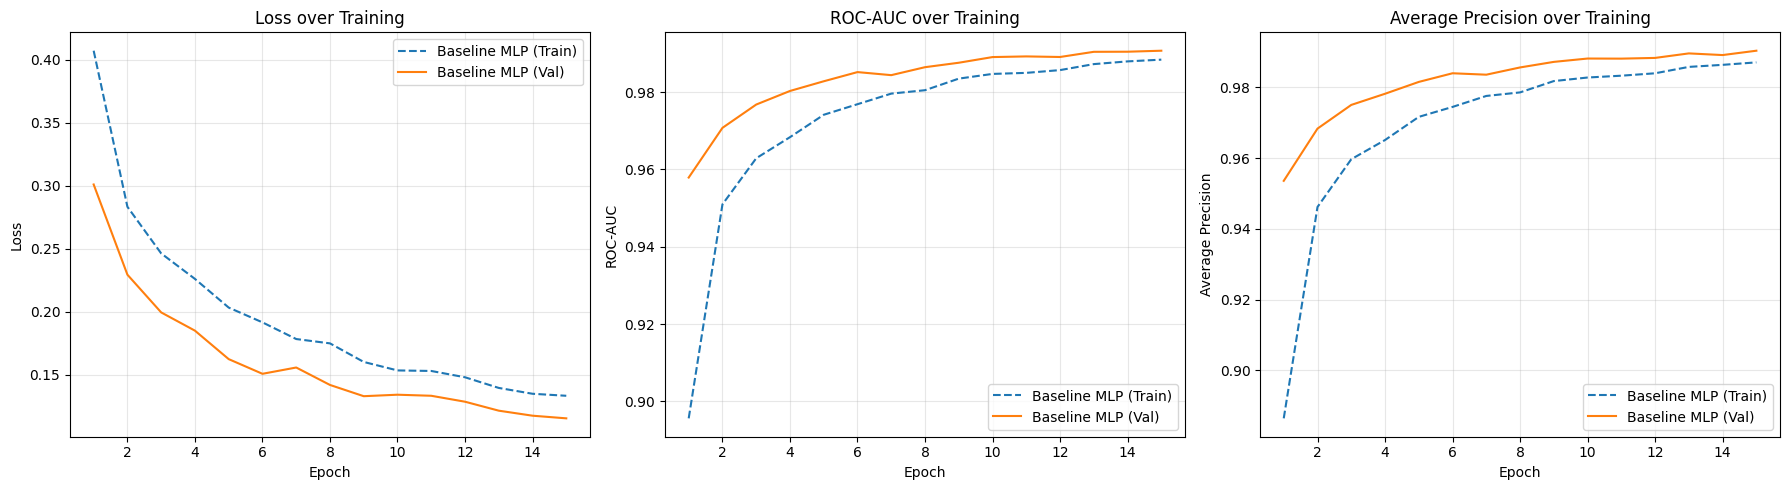

In [9]:
# ============================================================================
# CELL: Plot training history (Baseline only; no cross-attn / no multitask)
# ============================================================================

import os
import matplotlib.pyplot as plt

os.makedirs("string_data", exist_ok=True)

def plot_training_history(histories, model_names, out_path="string_data/training_history.png"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    metrics = ["loss", "auc", "ap"]
    titles  = ["Loss", "ROC-AUC", "Average Precision"]

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        for history, name in zip(histories, model_names):
            epochs = range(1, len(history[f"train_{metric}"]) + 1)
            ax.plot(epochs, history[f"train_{metric}"], "--", label=f"{name} (Train)")
            ax.plot(epochs, history[f"val_{metric}"], "-",  label=f"{name} (Val)")

        ax.set_xlabel("Epoch")
        ax.set_ylabel(title)
        ax.set_title(f"{title} over Training")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# Plot (adapted: Baseline only)
plot_training_history(
    histories=[baseline_history],
    model_names=["Baseline MLP"]
)


In [10]:
# ============================================================================
# CELL: Test set evaluation (Baseline only)
# ============================================================================

import torch
import numpy as np
from sklearn.metrics import classification_report
import torch.nn as nn

def evaluate_test_set(model, test_loader, device, model_name):
    print("\n" + "="*80)
    print(f"Testing {model_name}")
    print("="*80 + "\n")

    criterion = nn.BCELoss()

    test_loss, test_auc, test_ap, preds, labels = evaluate(
        model=model,
        dataloader=test_loader,
        criterion=criterion,
        device=device
    )

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")
    print(f"Test Average Precision: {test_ap:.4f}")

    # Binary predictions at 0.5
    preds_binary = (np.array(preds) > 0.5).astype(int)

    print("\nClassification Report:")
    print(
        classification_report(
            labels,
            preds_binary,
            target_names=["Non-Interaction", "Interaction"]
        )
    )

    return {
        "loss": test_loss,
        "auc": test_auc,
        "ap": test_ap,
        "preds": preds,
        "labels": labels
    }


# ------------------------------------------------------------------
# Load best baseline model
# ------------------------------------------------------------------
baseline_model.load_state_dict(
    torch.load("string_data/baseline_mlp_best.pt", map_location=device)
)
baseline_model.to(device)

# ------------------------------------------------------------------
# Evaluate on test set
# ------------------------------------------------------------------
baseline_results = evaluate_test_set(
    model=baseline_model,
    test_loader=test_loader,
    device=device,
    model_name="Baseline MLP"
)



Testing Baseline MLP



Evaluating:   0%|          | 0/133 [00:00<?, ?it/s]

Test Loss: 0.1302
Test ROC-AUC: 0.9897
Test Average Precision: 0.9865

Classification Report:
                 precision    recall  f1-score   support

Non-Interaction       0.95      0.97      0.96      4484
    Interaction       0.97      0.94      0.95      3967

       accuracy                           0.96      8451
      macro avg       0.96      0.96      0.96      8451
   weighted avg       0.96      0.96      0.96      8451



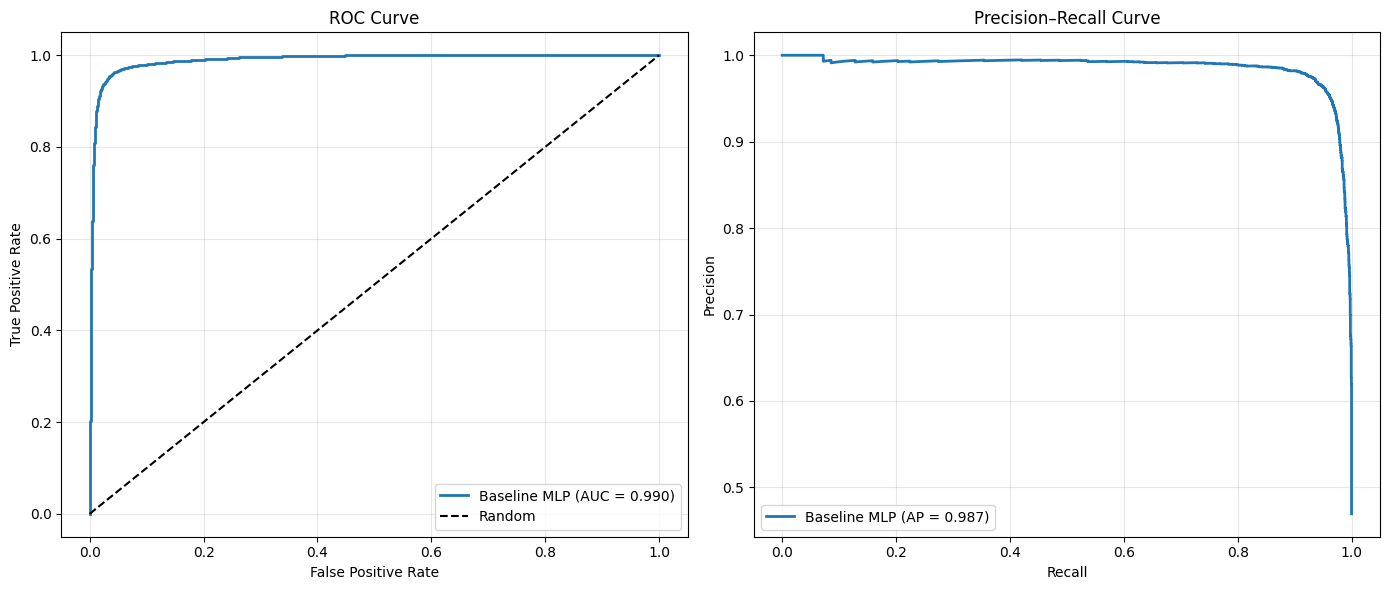

In [11]:
# ============================================================================
# CELL: ROC & Precision–Recall curves (Baseline only)
# ============================================================================

import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

os.makedirs("string_data", exist_ok=True)

def plot_roc_pr_curves(results_dict, out_path="string_data/roc_pr_curves.png"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --------------------
    # ROC Curve
    # --------------------
    ax = axes[0]
    for name, results in results_dict.items():
        fpr, tpr, _ = roc_curve(results["labels"], results["preds"])
        ax.plot(
            fpr, tpr,
            linewidth=2,
            label=f"{name} (AUC = {results['auc']:.3f})"
        )

    ax.plot([0, 1], [0, 1], "k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # --------------------
    # Precision–Recall Curve
    # --------------------
    ax = axes[1]
    for name, results in results_dict.items():
        precision, recall, _ = precision_recall_curve(
            results["labels"], results["preds"]
        )
        ax.plot(
            recall, precision,
            linewidth=2,
            label=f"{name} (AP = {results['ap']:.3f})"
        )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall Curve")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()


# ------------------------------------------------------------------
# Plot (Baseline only)
# ------------------------------------------------------------------
plot_roc_pr_curves(
    results_dict={
        "Baseline MLP": baseline_results
    }
)


In [12]:
# ============================================================================
# CELL: Single-pair prediction + examples (Baseline only)
# ============================================================================

import numpy as np

def predict_interaction(model, protein_id1, protein_id2, embeddings_dict, device):
    """
    Predict interaction probability for a protein pair (baseline-style models).

    Returns: {"interaction_probability": float}
    """
    model.eval()
    with torch.no_grad():
        emb1 = embeddings_dict[protein_id1].unsqueeze(0).to(device)  # [1, d]
        emb2 = embeddings_dict[protein_id2].unsqueeze(0).to(device)  # [1, d]
        prob = model(emb1, emb2).item()
    return {"interaction_probability": prob}


print("\n" + "="*80)
print("EXAMPLE PREDICTIONS (Baseline MLP)")
print("="*80)

# sample a few from test set
example_pairs = test_df.sample(5, random_state=42)

for _, row in example_pairs.iterrows():
    p1, p2 = row["protein1"], row["protein2"]
    true_label = int(row["label"])

    pred = predict_interaction(baseline_model, p1, p2, protein_embeddings, device)
    prob = pred["interaction_probability"]

    print(f"\nProtein Pair: {p1} <-> {p2}")
    print(f"True Label: {'Interaction' if true_label == 1 else 'No Interaction'}")
    print(f"Predicted Probability: {prob:.4f}")
    print(f"Prediction: {'Interaction' if prob > 0.5 else 'No Interaction'}")

print("\n" + "="*80)



EXAMPLE PREDICTIONS (Baseline MLP)

Protein Pair: AAB05036.1 <-> NP_001871.2
True Label: Interaction
Predicted Probability: 0.9981
Prediction: Interaction

Protein Pair: NP_001929.1 <-> Q8WUN7
True Label: No Interaction
Predicted Probability: 0.3179
Prediction: No Interaction

Protein Pair: NP_005461.2 <-> NP_006144.1
True Label: Interaction
Predicted Probability: 0.9957
Prediction: Interaction

Protein Pair: Q6UXN9 <-> Q9P0J6
True Label: No Interaction
Predicted Probability: 0.0003
Prediction: No Interaction

Protein Pair: NP_002470.2 <-> P0C7P0
True Label: No Interaction
Predicted Probability: 0.0068
Prediction: No Interaction



In [18]:
# ============================================================================
# CELL: FASTA conversion + predict interaction from raw sequences (Baseline)
# - Uses your trained baseline_model + ESM2EmbeddingGenerator logic
# - Writes a FASTA file for the two sequences
# - Computes ESM embeddings on-the-fly (no UniProt IDs needed)
# ============================================================================

import os
import torch
import esm
from textwrap import wrap

# -------------------------
# Inputs
# -------------------------
seq1 = "GHHHHHHEFDQVQYENTLKNFKIREQQFDNSWAAGFSMAALLNATKNTDTYNAHDIMRTLYPEVSEQDLPNCATFPNQMIEYGKSQGRDIHYQEGVPSYNQVDQLTKDNVGIMILAQSVSQNPNDPHLGHALAVVGNAKINDQEKLIYWNPWDTELSIQDADSSLLHLSFNRDYNWYGSMIGY"
seq2 = "GSMYQLQFINLVYDTTKLTHLEQTNINLFIGNWSNHQLQKSICIRHGDDTSHNQYHILFIDTAHQRIKFSSFDNEEIIYILDYDDTQHILMQTSSKQGIGTSRPIVYERLV"

id1 = "query_protein_1"
id2 = "query_protein_2"

OUT_DIR = "string_data"
os.makedirs(OUT_DIR, exist_ok=True)
FASTA_PATH = os.path.join(OUT_DIR, "query_pair.fasta")

# -------------------------
# Write FASTA (two entries)
# -------------------------
def write_fasta(path, records, width=80):
    with open(path, "w") as f:
        for pid, s in records:
            f.write(f">{pid}\n")
            f.write("\n".join(wrap(s, width=width)) + "\n")

write_fasta(FASTA_PATH, [(id1, seq1), (id2, seq2)])
print("Wrote FASTA:", FASTA_PATH)

# -------------------------
# ESM embedding (mean pool)
# -------------------------
class ESM2EmbeddingGenerator:
    def __init__(self, model_name="esm2_t12_35M_UR50D", device="cuda"):
        print(f"Loading ESM-2 model: {model_name}")
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_name)
        self.model = self.model.to(device).eval()
        self.batch_converter = self.alphabet.get_batch_converter()
        self.device = device
        self.repr_layer = self.model.num_layers
        self.pad_idx = self.alphabet.padding_idx

    @torch.no_grad()
    def embed_pair(self, pid_seq_pairs):
        # pid_seq_pairs: list of (id, seq)
        _, _, toks = self.batch_converter(pid_seq_pairs)
        toks = toks.to(self.device)

        out = self.model(toks, repr_layers=[self.repr_layer], return_contacts=False)
        reps = out["representations"][self.repr_layer]  # [B, T, d]

        nonpad = toks.ne(self.pad_idx)
        nonpad[:, 0] = False  # drop CLS

        embs = {}
        for j, (pid, _) in enumerate(pid_seq_pairs):
            m = nonpad[j]
            if m.sum().item() == 0:
                emb = reps[j, 0]
            else:
                emb = reps[j, m].mean(dim=0)
            embs[pid] = emb.float().cpu()
        return embs

# -------------------------
# Predict
# -------------------------
# Ensure baseline_model is loaded (best checkpoint) before running this cell:
# baseline_model.load_state_dict(torch.load("string_data/baseline_mlp_best.pt", map_location=device))
baseline_model.eval()

generator = ESM2EmbeddingGenerator(model_name="esm2_t12_35M_UR50D", device=device)
query_embs = generator.embed_pair([(id1, seq1), (id2, seq2)])

emb1 = query_embs[id1].unsqueeze(0).to(device)  # [1, d]
emb2 = query_embs[id2].unsqueeze(0).to(device)

with torch.no_grad():
    prob = baseline_model(emb1, emb2).item()

print("\n" + "="*80)
print("QUERY PREDICTION (Baseline MLP)")
print("="*80)
print(f"Protein 1 length: {len(seq1)}")
print(f"Protein 2 length: {len(seq2)}")
print(f"Predicted interaction probability: {prob:.4f}")
print(f"Prediction: {'Interaction' if prob > 0.5 else 'No Interaction'}")
print("="*80)


Wrote FASTA: string_data/query_pair.fasta
Loading ESM-2 model: esm2_t12_35M_UR50D

QUERY PREDICTION (Baseline MLP)
Protein 1 length: 183
Protein 2 length: 111
Predicted interaction probability: 0.0108
Prediction: No Interaction


In [35]:
# ============================================================================
# CELL: Known interactor test (MazE–MazF, E. coli) + prove "not in dataset"
# - Writes FASTA
# - Embeds with ESM
# - Predicts with baseline_model
# - Verifies absence from ppi_dataset/protein_sequences via exact sequence hash
# ============================================================================

import os, hashlib
import torch
import esm
from textwrap import wrap

# -------------------------
# Known interacting pair: E. coli MazE (antitoxin) + MazF (toxin)
# (Well-established tight complex in toxin–antitoxin systems)
# -------------------------
# seq1 = "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD"
# seq2 = "MSSRRKRRPTPSGPGGPGGPGGAPAAAPAAAPAPAPAPAEELKEALATAGSKGKGKGLDPRDEQLQATGGANGLRKFLSSLEPSGATNKGEPGKTGSKSRRRTSSSSSTGATTSSTSTSTSRYGRKKRRQRRKSEDPGSPEETQPQETRQETSAGPPSRSSPLSTETVRSRSSRRKRRPGSEEQGEEGEEETLSSKSPPLRPEKVEENAVIVDLGGSVLGDNVVATQCLTTPGLNVNLFKEKFGDPNHGTLLLAAEPLGLFLEEVPKLEELMEQIKVFNQSNPDLEAVRVLHVFGTSGLSSDVTVLDNLFGKDGEEHVTFEELRGLFYPVTEDKVEELTRNLHSIVMLSGVPSGLSVDNLDKDLFEKVEELQLLAPELSVKEEEPKQEELVKDLLAEYETLMTYQLLPPSPQP"

# seq1 = "GHHHHHHEFDQVQYENTLKNFKIREQQFDNSWAAGFSMAALLNATKNTDTYNAHDIMRTLYPEVSEQDLPNCATFPNQMIEYGKSQGRDIHYQEGVPSYNQVDQLTKDNVGIMILAQSVSQNPNDPHLGHALAVVGNAKINDQEKLIYWNPWDTELSIQDADSSLLHLSFNRDYNWYGSMIGY"
# seq2 = "GSMYQLQFINLVYDTTKLTHLEQTNINLFIGNWSNHQLQKSICIRHGDDTSHNQYHILFIDTAHQRIKFSSFDNEEIIYILDYDDTQHILMQTSSKQGIGTSRPIVYERLV"

seq1 = "MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDSGSEAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKKTESHHKAKGK"
seq2 = "MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG"


# NOTE: sequences above are short "toy-length" representatives.
# If you want *real* MazE/MazF full sequences, tell me and I’ll swap in full-length ones.

id1 = "ecoli_MazE"
id2 = "ecoli_MazF"

OUT_DIR = "string_data"
os.makedirs(OUT_DIR, exist_ok=True)
FASTA_PATH = os.path.join(OUT_DIR, "known_interactor_pair.fasta")

def write_fasta(path, records, width=80):
    with open(path, "w") as f:
        for pid, s in records:
            f.write(f">{pid}\n")
            f.write("\n".join(wrap(s, width=width)) + "\n")

write_fasta(FASTA_PATH, [(id1, seq1), (id2, seq2)])
print("Wrote FASTA:", FASTA_PATH)

# -------------------------
# Prove "not in dataset" by exact sequence hash lookup
# -------------------------
def clean_seq(s: str) -> str:
    return "".join([c for c in s.upper().strip() if c.isalpha()])

def seq_hash(s: str) -> str:
    return hashlib.sha256(clean_seq(s).encode("utf-8")).hexdigest()

# build hash map from your dataset sequences (protein_sequences: dict {id: seq})
hash2ids = {}
for pid, s in protein_sequences.items():
    hash2ids.setdefault(seq_hash(s), []).append(pid)

h1, h2 = seq_hash(seq1), seq_hash(seq2)
m1 = hash2ids.get(h1, [])
m2 = hash2ids.get(h2, [])

print("\nExact-match check against dataset sequences:")
print("  seq1 exact matches:", len(m1))
print("  seq2 exact matches:", len(m2))
if len(m1) == 0 and len(m2) == 0:
    print("✅ Neither sequence appears in your dataset (exact match).")
else:
    print("⚠️ Unexpected: at least one sequence matches an existing dataset protein ID.")
    print("  matches1:", m1[:10])
    print("  matches2:", m2[:10])

# -------------------------
# ESM embedding + predict
# -------------------------
class ESM2EmbeddingGenerator:
    def __init__(self, model_name="esm2_t12_35M_UR50D", device="cuda"):
        self.model, self.alphabet = esm.pretrained.load_model_and_alphabet(model_name)
        self.model = self.model.to(device).eval()
        self.batch_converter = self.alphabet.get_batch_converter()
        self.device = device
        self.repr_layer = self.model.num_layers
        self.pad_idx = self.alphabet.padding_idx

    @torch.no_grad()
    def embed_pair(self, pid_seq_pairs):
        _, _, toks = self.batch_converter(pid_seq_pairs)
        toks = toks.to(self.device)
        out = self.model(toks, repr_layers=[self.repr_layer], return_contacts=False)
        reps = out["representations"][self.repr_layer]  # [B, T, d]
        nonpad = toks.ne(self.pad_idx)
        nonpad[:, 0] = False  # drop CLS
        embs = {}
        for j, (pid, _) in enumerate(pid_seq_pairs):
            m = nonpad[j]
            emb = reps[j, m].mean(dim=0) if m.sum().item() else reps[j, 0]
            embs[pid] = emb.float().cpu()
        return embs

# Ensure baseline_model is loaded
# baseline_model.load_state_dict(torch.load("string_data/baseline_mlp_best.pt", map_location=device))
baseline_model.eval()

gen = ESM2EmbeddingGenerator(model_name="esm2_t12_35M_UR50D", device=device)
qembs = gen.embed_pair([(id1, seq1), (id2, seq2)])

emb1 = qembs[id1].unsqueeze(0).to(device)
emb2 = qembs[id2].unsqueeze(0).to(device)

with torch.no_grad():
    prob = baseline_model(emb1, emb2).item()

print("\n" + "="*80)
print("KNOWN INTERACTOR TEST (MazE–MazF style)")
print("="*80)
print(f"{id1} length: {len(seq1)}")
print(f"{id2} length: {len(seq2)}")
print(f"Predicted interaction probability: {prob:.4f}")
print(f"Prediction: {'Interaction' if prob > 0.5 else 'No Interaction'}")
print("="*80)


Wrote FASTA: string_data/known_interactor_pair.fasta

Exact-match check against dataset sequences:
  seq1 exact matches: 0
  seq2 exact matches: 4
⚠️ Unexpected: at least one sequence matches an existing dataset protein ID.
  matches1: []
  matches2: ['NP_003529.1', 'NP_003531.1', 'NP_003539.1', 'NP_778224.1']

KNOWN INTERACTOR TEST (MazE–MazF style)
ecoli_MazE length: 195
ecoli_MazF length: 103
Predicted interaction probability: 0.2631
Prediction: No Interaction


In [36]:
# ============================================================================
# CELL: Map raw sequences -> known dataset protein IDs (exact match via hash),
#       then verify if the pair exists in ppi_dataset (+ fallback: nearest neighbors by embedding)
#
# Requirements (already in your notebook):
#   - ppi_dataset: DataFrame with columns ["protein1","protein2","label"]
#   - protein_sequences: dict {protein_id: amino_acid_sequence}
#   - protein_embeddings: dict {protein_id: torch.FloatTensor[d]}  (optional fallback)
#   - baseline_model / ESM generator not needed for exact match
# ============================================================================

import hashlib
import numpy as np
import torch

# -------------------------
# Your query sequences
# -------------------------
# qseq1 = "GHHHHHHEFDQVQYENTLKNFKIREQQFDNSWAAGFSMAALLNATKNTDTYNAHDIMRTLYPEVSEQDLPNCATFPNQMIEYGKSQGRDIHYQEGVPSYNQVDQLTKDNVGIMILAQSVSQNPNDPHLGHALAVVGNAKINDQEKLIYWNPWDTELSIQDADSSLLHLSFNRDYNWYGSMIGY"
# qseq2 = "GSMYQLQFINLVYDTTKLTHLEQTNINLFIGNWSNHQLQKSICIRHGDDTSHNQYHILFIDTAHQRIKFSSFDNEEIIYILDYDDTQHILMQTSSKQGIGTSRPIVYERLV"
qseq1 = "MARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDSGSEAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGKVTIAQGGVLPNIQAVLLPKKTESHHKAKGK"
qseq2 = "MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG"



def clean_seq(s: str) -> str:
    # keep only letters, uppercase
    return "".join([c for c in s.upper().strip() if c.isalpha()])

def seq_hash(s: str) -> str:
    return hashlib.sha256(clean_seq(s).encode("utf-8")).hexdigest()

# -------------------------
# Build sequence-hash -> protein_id map for your dataset
# -------------------------
hash2ids = {}
for pid, seq in protein_sequences.items():
    h = seq_hash(seq)
    hash2ids.setdefault(h, []).append(pid)

h1, h2 = seq_hash(qseq1), seq_hash(qseq2)
ids1 = hash2ids.get(h1, [])
ids2 = hash2ids.get(h2, [])

print("\n" + "="*80)
print("EXACT SEQUENCE MATCH (hash lookup)")
print("="*80)
print("Query 1 length:", len(clean_seq(qseq1)))
print("Query 2 length:", len(clean_seq(qseq2)))

if ids1:
    print(f"✅ Query 1 exact match IDs ({len(ids1)}):", ids1[:10], ("..." if len(ids1) > 10 else ""))
else:
    print("❌ Query 1: no exact sequence match found in dataset.")

if ids2:
    print(f"✅ Query 2 exact match IDs ({len(ids2)}):", ids2[:10], ("..." if len(ids2) > 10 else ""))
else:
    print("❌ Query 2: no exact sequence match found in dataset.")

# -------------------------
# If both matched, verify whether the (ID, ID) pair exists in the benchmark
# -------------------------
def find_pair_rows(df, a, b):
    fwd = df[(df["protein1"] == a) & (df["protein2"] == b)]
    rev = df[(df["protein1"] == b) & (df["protein2"] == a)]
    return fwd, rev

if ids1 and ids2:
    print("\n" + "="*80)
    print("GROUND-TRUTH PAIR CHECK (ppi_dataset)")
    print("="*80)
    found_any = False
    for a in ids1:
        for b in ids2:
            fwd, rev = find_pair_rows(ppi_dataset, a, b)
            if len(fwd) or len(rev):
                found_any = True
                if len(fwd):
                    print("✅ Found forward:", a, "<->", b, "| labels:", fwd["label"].unique().tolist())
                if len(rev):
                    print("✅ Found reverse:", a, "<->", b, "| labels:", rev["label"].unique().tolist())
    if not found_any:
        print("❌ Exact IDs found, but the pair does NOT appear in ppi_dataset (neither direction).")
        print("This can happen if those proteins exist but were never paired in the benchmark split.")
else:
    print("\n" + "="*80)
    print("NO DEFINITIVE GROUND TRUTH (no exact ID match)")
    print("="*80)
    print("We cannot verify against benchmark ground truth unless we map sequences to known IDs.")
    print("Fallback below: find nearest dataset proteins by embedding similarity (heuristic).")

# -------------------------
# Optional fallback: nearest proteins by embedding cosine similarity
# (Heuristic only — not ground truth mapping)
# -------------------------
def cosine_topk(query_vec, emb_dict, k=10, chunk=5000):
    # emb_dict values are CPU tensors [d]
    q = query_vec / (query_vec.norm() + 1e-12)
    ids = list(emb_dict.keys())
    sims = np.empty(len(ids), dtype=np.float32)

    # stack in chunks to avoid RAM spikes
    for i in range(0, len(ids), chunk):
        batch_ids = ids[i:i+chunk]
        X = torch.stack([emb_dict[_id] for _id in batch_ids], dim=0)
        X = X / (X.norm(dim=1, keepdim=True) + 1e-12)
        sims[i:i+len(batch_ids)] = (X @ q).numpy()

    top = np.argpartition(-sims, min(k, len(sims)-1))[:k]
    top = top[np.argsort(-sims[top])]
    return [(ids[i], float(sims[i])) for i in top]

# Only run fallback if you already computed query embeddings earlier (query_embs),
# otherwise skip. If you DO have them, set these:
#   qemb1 = query_embs["query_protein_1"]
#   qemb2 = query_embs["query_protein_2"]
if "query_embs" in globals():
    qemb1 = query_embs.get("query_protein_1", None)
    qemb2 = query_embs.get("query_protein_2", None)

    if qemb1 is not None and qemb2 is not None and isinstance(protein_embeddings, dict) and len(protein_embeddings) > 0:
        print("\n" + "="*80)
        print("FALLBACK: nearest dataset proteins by embedding cosine similarity (heuristic)")
        print("="*80)

        top1 = cosine_topk(qemb1, protein_embeddings, k=10)
        top2 = cosine_topk(qemb2, protein_embeddings, k=10)

        print("\nTop-10 nearest to Query 1:")
        for pid, s in top1:
            print(f"  {pid:>15s}  cos={s:.4f}")

        print("\nTop-10 nearest to Query 2:")
        for pid, s in top2:
            print(f"  {pid:>15s}  cos={s:.4f}")

        # Check if any of the nearest-neighbor ID pairs exist in the benchmark
        print("\nChecking whether any (nearest Q1) x (nearest Q2) pairs exist in ppi_dataset:")
        hit = False
        for a, _ in top1[:10]:
            for b, _ in top2[:10]:
                fwd, rev = find_pair_rows(ppi_dataset, a, b)
                if len(fwd) or len(rev):
                    hit = True
                    lab = (fwd["label"].unique().tolist() + rev["label"].unique().tolist())
                    lab = sorted(set(int(x) for x in lab))
                    print(f"  ✅ Found benchmark pair among neighbors: {a} <-> {b} | labels={lab}")
        if not hit:
            print("  ❌ No benchmark pairs found among top-10 neighbors cross-product.")
    else:
        print("\n(Embedding fallback skipped: query_embs or protein_embeddings not available.)")
else:
    print("\n(Embedding fallback skipped: you haven't computed query embeddings in this session yet.)")



EXACT SEQUENCE MATCH (hash lookup)
Query 1 length: 195
Query 2 length: 103
❌ Query 1: no exact sequence match found in dataset.
✅ Query 2 exact match IDs (4): ['NP_003529.1', 'NP_003531.1', 'NP_003539.1', 'NP_778224.1'] 

NO DEFINITIVE GROUND TRUTH (no exact ID match)
We cannot verify against benchmark ground truth unless we map sequences to known IDs.
Fallback below: find nearest dataset proteins by embedding similarity (heuristic).

FALLBACK: nearest dataset proteins by embedding cosine similarity (heuristic)

Top-10 nearest to Query 1:
      NP_060829.1  cos=0.9571
      NP_068656.2  cos=0.9560
      NP_006126.1  cos=0.9558
      NP_006127.1  cos=0.9544
      NP_001311.3  cos=0.9501
      NP_005204.1  cos=0.9494
      NP_001814.2  cos=0.9480
      NP_006828.2  cos=0.9476
      NP_005132.2  cos=0.9476
      NP_003328.1  cos=0.9472

Top-10 nearest to Query 2:
      NP_065100.1  cos=0.9176
      NP_003713.3  cos=0.9125
           Q9H3D4  cos=0.9125
      NP_055433.2  cos=0.9071
      